The purpose of this Jupyter notebook is to demonstrate my data science library.

I'm going to use the Titanic dataset so the first section is about preparing the data for visualization/analysis.

# Prepare/clean data
## Import dependencies

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/Users/cmshymansky/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Import data

In [2]:
df = pd.read_csv('./data/titanic-train.csv')

## Derive title from name

In [3]:
df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

In [4]:
df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip()).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [5]:
title_map = {'Mr': 'Mr',
'Miss': 'Miss',
'Mrs': 'Mrs',
'Master': 'Child',
'Dr': 'Dr',
'Don': 'Noble',
'Rev': 'Rev',
'Ms': 'Miss',
'Mme': 'Miss',
'Major': 'Military',
'Col': 'Military',
'Capt': 'Military',
'the Countess': 'Noble',
'Major': 'Military',
'Mlle': 'Miss', 
'Jonkheer': 'Noble',
'Lady': 'Noble',
'Sir': 'Noble'} 

df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
df['Title'] = df.Title.map(title_map)

df['Title'].value_counts()

Mr          517
Miss        186
Mrs         125
Child        40
Dr            7
Rev           6
Military      5
Noble         5
Name: Title, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


## Replace missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


There is missing Age, Cabin, and Embarked data. 

There is so much missing Cabin data it should probably just be discarded.

Let's look at the distribution for Embarked:

In [8]:
print df['Embarked'].value_counts()
print df['Embarked'].value_counts()/df['Embarked'].value_counts().sum()

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64


There is such a high percentage of S cabins and only 3 entries don't have this data filling the blanks with S (highest frequency) is probably rather good:

In [9]:
df['Embarked'].fillna('S',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


Let's look at the 'Age' data:

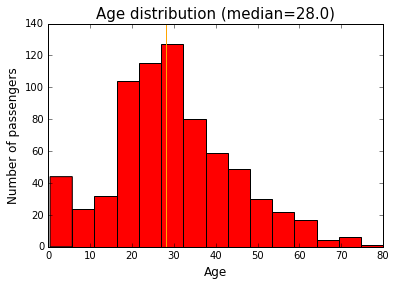

In [10]:
# Obtain median Age
median_age = df['Age'].median()

# Plot a quick histogram of it:
df['Age'].plot.hist(bins=15,color='r')

# Set title
plt.title('Age distribution (median=%.1f)'%(median_age),size=15)

# Set labels
plt.xlabel('Age',size=12)
plt.ylabel('Number of passengers',size=12)

# Add vertical median line
plt.axvline(median_age,color='orange')

The median age can be used to fill in the other data as a first stab.

However, I'm interested in seeing if we can model the age instead. Let's go ahead and one-hot encode the varaibles other than age.

In [11]:
# df['Age'].fillna(median_age,inplace=True)
simulation_df = df.copy()
del simulation_df['PassengerId']
del simulation_df['Cabin']
del simulation_df['Ticket']
del simulation_df['Name']
simulation_df = pd.get_dummies(simulation_df,drop_first=True)
simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
Survived          891 non-null int64
Pclass            891 non-null int64
Age               714 non-null float64
SibSp             891 non-null int64
Parch             891 non-null int64
Fare              891 non-null float64
Sex_male          891 non-null float64
Embarked_Q        891 non-null float64
Embarked_S        891 non-null float64
Title_Dr          891 non-null float64
Title_Military    891 non-null float64
Title_Miss        891 non-null float64
Title_Mr          891 non-null float64
Title_Mrs         891 non-null float64
Title_Noble       891 non-null float64
Title_Rev         891 non-null float64
dtypes: float64(12), int64(4)
memory usage: 111.4 KB


Now we need to split the data for that has values (not null) for the Age feature so we can use it to train a model that we'll use to replace the N/A values.

In [12]:
age_df = simulation_df[pd.notnull(simulation_df['Age'])]

In [13]:
age_df.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Dr,Title_Military,Title_Miss,Title_Mr,Title_Mrs,Title_Noble,Title_Rev
0,0,3,22.0,1,0,7.2500,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1,38.0,1,0,71.2833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,3,35.0,0,0,8.0500,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0,1,54.0,0,0,51.8625,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0,3,2.0,3,1,21.0750,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,3,27.0,0,2,11.1333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1,2,14.0,1,0,30.0708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,1,3,4.0,1,1,16.7000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Then we have to split the data into input feature and output feature data:

In [14]:
output_feature = 'Age'
column_names = list(age_df.columns)

# Exclude one of every categorical variable since the other one-hot encodings cover everything
input_features = [x for x in column_names if x != output_feature]

# Split into features and responses
X = age_df[input_features].copy()
y = age_df[output_feature].copy()

Finally, we perform a polynomial regression using degrees 1 to 5 and use GridSearchCV 

In [15]:
%%time 
import data_science_lib
reload(data_science_lib)
        
# Figure out best model
pipeline = data_science_lib.train_model(X,y,
           estimator='polynomial_regression',
           num_parameter_combos=[],
           use_default_param_dist=True)

/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Grid parameters:
pre_estimator__degree : [1, 2, 3, 4]


/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)



Training L2 norm score:  130.719447349

Test L2 norm score:  125.590523058

Best parameters:

{'pre_estimator__degree': 1}

Pipeline(steps=[('pre_estimator', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('estimator', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
CPU times: user 557 ms, sys: 227 ms, total: 784 ms
Wall time: 6.69 s


Replace null values with model prediction:

In [16]:
for index, row in simulation_df.iterrows():
    if pd.isnull(row[output_feature]):
        X = row[input_features]
        simulation_df[output_feature][index] = pipeline.predict(X.reshape(1,-1))[0]

/Users/cmshymansky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
simulation_df[pd.isnull(simulation_df['Age'])]

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Dr,Title_Military,Title_Miss,Title_Mr,Title_Mrs,Title_Noble,Title_Rev


Visualize distributions before and after replacement

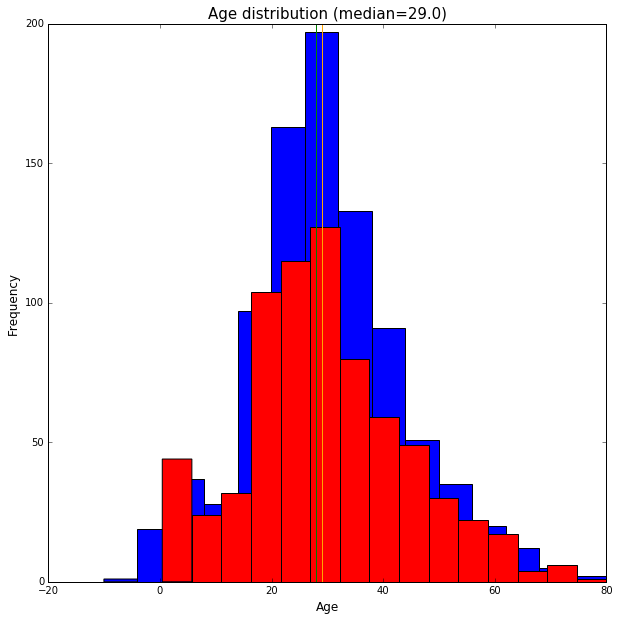

In [18]:
# Obtain median Age
median_age = simulation_df['Age'].median()

# Plot a quick histogram of it:
simulation_df['Age'].plot.hist(bins=15,color='b',figsize=(10,10))

# Set title
plt.title('Age distribution (median=%.1f)'%(median_age),size=15)

# Set labels
plt.xlabel('Age',size=12)
plt.ylabel('Number of passengers',size=12)

# Add vertical median line
plt.axvline(median_age,color='orange')

# Obtain median Age
median_age = df['Age'].median()

# Plot a quick histogram of it:
df['Age'].plot.hist(bins=15,color='r')


# Add vertical median line
plt.axvline(median_age,color='green')

Shifted the median just a bit.

# Predict Survival

## Null accuracy

In [19]:
simulation_df['Survived'].value_counts().values/float(simulation_df['Survived'].value_counts().values.sum())

array([ 0.61616162,  0.38383838])

Null accuracy of ~62% if always predict death.

# Train models
## Split data

In [20]:
# Set output feature
output_feature = 'Survived'

# Get all column names
column_names = list(simulation_df.columns)

# Exclude one of every categorical variable since the other one-hot encodings cover everything
input_features = [x for x in column_names if x != output_feature]

# Split into features and responses
X = simulation_df[input_features].copy()
y = simulation_df[output_feature].copy()

## Standard scaling, SelectKBest, and KNN

In [22]:
%%time 
import data_science_lib
reload(data_science_lib)
        
# Figure out best model
pipeline = data_science_lib.train_model(X,y,
           scale_type='standard',
           feature_selection_type='select_k_best',
           estimator='knn',
           num_parameter_combos=[],
           use_default_param_dist=True)

Grid parameters:
estimator__n_neighbors : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
feature_selection__k : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
estimator__weights : ['uniform', 'distance']

Training set classification accuracy:  0.831460674157

Test set classification accuracy:  0.832402234637
Confusion matrix: 

[[102  11]
 [ 19  47]]

Normalized confusion matrix: 

[[ 0.5698324   0.06145251]
 [ 0.10614525  0.26256983]]

Classification report: 

             precision    recall  f1-score   support

          0       0.84      0.90      0.87       113
          1       0.81      0.71      0.76        66

avg / total       0.83      0.83      0.83       179


Best parameters:

{'estimator__n_neighbors': 8, 'feature_selection__k': 15, 'estimator__weights': 'uniform'}

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=15, score_func=<

## Standard scaler, SelectKBest, and LogisticRegression

In [23]:
%%time 
import data_science_lib
reload(data_science_lib)
        
# Figure out best model
pipeline = data_science_lib.train_model(X,y,
           scale_type='standard',
           feature_selection_type='select_k_best',
           estimator='logistic_regression',
           num_parameter_combos=[],
           use_default_param_dist=True)

Grid parameters:
feature_selection__k : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
estimator__C : [  1.00000000e-10   1.00000000e-05   1.00000000e+00   1.00000000e+05
   1.00000000e+10]

Training set classification accuracy:  0.831460674157

Test set classification accuracy:  0.837988826816
Confusion matrix: 

[[96 10]
 [19 54]]

Normalized confusion matrix: 

[[ 0.53631285  0.05586592]
 [ 0.10614525  0.30167598]]

Classification report: 

             precision    recall  f1-score   support

          0       0.83      0.91      0.87       106
          1       0.84      0.74      0.79        73

avg / total       0.84      0.84      0.84       179


Best parameters:

{'feature_selection__k': 15, 'estimator__C': 1.0}

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=15, score_func=<function f_classif at 0x119246e60>)), ('estimator', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=T

## Scale, feature select, support vector machine

In [24]:
%%time 
import data_science_lib
reload(data_science_lib)
        
# Figure out best model
pipeline = data_science_lib.train_model(X,y,
           scale_type='standard',
           feature_selection_type='select_k_best',
           estimator='svm',
           num_parameter_combos=[],
           use_default_param_dist=True)

Grid parameters:
feature_selection__k : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Training set classification accuracy:  0.838483146067

Test set classification accuracy:  0.810055865922
Confusion matrix: 

[[97 14]
 [20 48]]

Normalized confusion matrix: 

[[ 0.54189944  0.07821229]
 [ 0.11173184  0.26815642]]

Classification report: 

             precision    recall  f1-score   support

          0       0.83      0.87      0.85       111
          1       0.77      0.71      0.74        68

avg / total       0.81      0.81      0.81       179


Best parameters:

{'feature_selection__k': 13}

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=13, score_func=<function f_classif at 0x119246e60>)), ('estimator', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,


## Scale, PCA, feature select, svm

In [25]:
%%time 
import data_science_lib
reload(data_science_lib)
        
# Figure out best model
pipeline = data_science_lib.train_model(X,y,
                                        scale_type='standard',
                                        transform_type='pca',
                                        feature_selection_type='select_k_best',
                                        estimator='svm',
                                        num_parameter_combos=[],
                                        use_default_param_dist=True)

Grid parameters:
feature_selection__k : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Training set classification accuracy:  0.842696629213

Test set classification accuracy:  0.793296089385
Confusion matrix: 

[[102  21]
 [ 16  40]]

Normalized confusion matrix: 

[[ 0.5698324   0.11731844]
 [ 0.08938547  0.22346369]]

Classification report: 

             precision    recall  f1-score   support

          0       0.86      0.83      0.85       123
          1       0.66      0.71      0.68        56

avg / total       0.80      0.79      0.80       179


Best parameters:

{'feature_selection__k': 9}

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('transform', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('feature_selection', SelectKBest(k=9, score_func=<function f_classif at 0x119246e60>))...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,


## Scale, SelectKBest, Multilayer Perceptron

In [43]:
%%time 
import data_science_lib
reload(data_science_lib)
        
# Figure out best model
pipeline = data_science_lib.train_model(X,y,
                                        scale_type='standard', 
                                        feature_selection_type='select_k_best',
                                        estimator='multilayer_perceptron',                                    
                                        num_parameter_combos=70,
                                        use_default_param_dist=True)

Grid parameters:
feature_selection__k : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
estimator__hidden_layer_sizes : [[3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15]]

Training set classification accuracy:  0.834269662921

Test set classification accuracy:  0.810055865922
Confusion matrix: 

[[99 17]
 [17 46]]

Normalized confusion matrix: 

[[ 0.55307263  0.09497207]
 [ 0.09497207  0.25698324]]

Classification report: 

             precision    recall  f1-score   support

          0       0.85      0.85      0.85       116
          1       0.73      0.73      0.73        63

avg / total       0.81      0.81      0.81       179


Best parameters:

{'feature_selection__k': 11, 'estimator__hidden_layer_sizes': [4]}

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=11, score_func=<function f_classif at 0x119246e60>)), ('estimator', MLPClassifier(activation='relu', alpha=1e-05, batch_si

## Scale, PCA, SelectKBest, Multilayer Perceptron

In [42]:
%%time 
import data_science_lib
reload(data_science_lib)
        
# Figure out best model
pipeline = data_science_lib.train_model(X,y,
                                        scale_type='standard', 
                                        transform_type='pca',
                                        feature_selection_type='select_k_best',
                                        estimator='multilayer_perceptron',                                    
                                        num_parameter_combos=100,
                                        use_default_param_dist=True)

Grid parameters:
feature_selection__k : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
estimator__hidden_layer_sizes : [[3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15]]

Training set classification accuracy:  0.832865168539

Test set classification accuracy:  0.826815642458
Confusion matrix: 

[[91 13]
 [18 57]]

Normalized confusion matrix: 

[[ 0.50837989  0.0726257 ]
 [ 0.10055866  0.31843575]]

Classification report: 

             precision    recall  f1-score   support

          0       0.83      0.88      0.85       104
          1       0.81      0.76      0.79        75

avg / total       0.83      0.83      0.83       179


Best parameters:

{'feature_selection__k': 5, 'estimator__hidden_layer_sizes': [5]}

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('transform', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('feature_selection', S

/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14] are constant.
  UserWarning)
/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14] are constant.
  UserWarning)
/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14] are constant.
  UserWarning)
/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [14] are constant.
  UserWarning)


## Scale, SelectKBest, Random forest

In [46]:
%%time 
import data_science_lib
reload(data_science_lib)
        
# Figure out best model
pipeline = data_science_lib.train_model(X,y,
                                        scale_type='standard', 
                                        feature_selection_type='select_k_best',
                                        estimator='random_forest',                                    
                                        num_parameter_combos=20,
                                        use_default_param_dist=True)

Grid parameters:
feature_selection__k : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
estimator__n_estimators : [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Training set classification accuracy:  0.832865168539

Test set classification accuracy:  0.826815642458
Confusion matrix: 

[[94  7]
 [24 54]]

Normalized confusion matrix: 

[[ 0.52513966  0.03910615]
 [ 0.13407821  0.30167598]]

Classification report: 

             precision    recall  f1-score   support

          0       0.80      0.93      0.86       101
          1       0.89      0.69      0.78        78

avg / total       0.84      0.83      0.82       179


Best parameters:

{'feature_selection__k': 13, 'estimator__n_estimators': 97}

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=13, score_func=<function f_classif at 0x119246e60>)), ('estimator', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=

## ExtraTreesClassifier

In [ ]:
%%time 

# Set output feature
output_feature = 'Survived'

# Get all column names
column_names = list(simulation_df.columns)

# Exclude one of every categorical variable since the other one-hot encodings cover everything
input_features = [x for x in column_names if x != output_feature]

# Split into features and responses
X = simulation_df[input_features].copy()
y = simulation_df[output_feature].copy()

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer

# Feature selection tools
from sklearn.feature_selection import SelectKBest, f_classif

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

# Regression tools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Unsupervised learning tools
from sklearn.decomposition import PCA
from sklearn.lda import LDA

# Cross validation tools
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Form pipeline
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif)),         
        ('classifier', ExtraTreesClassifier(max_depth=4,learning_rate=0.01,min_samples_split=1))
    ])

# Initialize grid search with pipeline
grid_search = GridSearchCV(pipeline, {
        'classifier__n_estimators': [300],
        'classifier__loss' : [ 'ls', 'lad' ],
        'feature_selection__k': range(1,len(input_features))
#         'unsupervised__n_components': range(1,5)
    },
    cv=10, 
    scoring='accuracy',
    n_jobs=-1)

# Print grid_search parameters
print grid_search

# Split data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

# Perform grid serach using above parameters
grid_search.fit(X_train, y_train)

# Make prediction based on model
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print out metrics and best parameters
print 'Confusion matrix: \n\n',conf_mat

print '\nNormalized confusion matrix: \n\n',conf_mat/float(conf_mat.sum())

print '\nClassification report: \n\n',classification_report(y_test, y_pred)

print '\nTraining set classification accuracy: ',grid_search.best_score_
print '\nTest set classification accuracy: ',conf_mat.trace()/float(conf_mat.sum())
print '\nBest parameters:\n'
print grid_search.best_params_

# Fit pipeline with best parameters obtained from grid search using all data
pipeline.set_params(**grid_search.best_params_).fit(X, y)

y_pred_pipe = pipeline.predict(X_test)

# Calculate confusion matrix
conf_mat_pipe = confusion_matrix(y_test, y_pred_pipe)
print conf_mat_pipe

## Gradient booster

In [ ]:
%%time 

# Set output feature
output_feature = 'Survived'

# Get all column names
column_names = list(simulation_df.columns)

# Exclude one of every categorical variable since the other one-hot encodings cover everything
input_features = [x for x in column_names if x != output_feature]

# Split into features and responses
X = simulation_df[input_features].copy()
y = simulation_df[output_feature].copy()

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer

# Feature selection tools
from sklearn.feature_selection import SelectKBest, f_classif

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor

# Regression tools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Unsupervised learning tools
from sklearn.decomposition import PCA
from sklearn.lda import LDA

# Cross validation tools
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Form pipeline
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif)),         
        ('classifier', GradientBoostingRegressor())
    ])

# Initialize grid search with pipeline
grid_search = GridSearchCV(pipeline, {
        'classifier__n_estimators': [x for x in range(190,210)],
        'feature_selection__k': range(1,len(input_features))
#         'unsupervised__n_components': range(1,5)
    },
    cv=10, 
    scoring='accuracy',
    n_jobs=-1)

# Print grid_search parameters
print grid_search

# Split data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

# Perform grid serach using above parameters
grid_search.fit(X_train, y_train)

# Make prediction based on model
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print out metrics and best parameters
print 'Confusion matrix: \n\n',conf_mat

print '\nNormalized confusion matrix: \n\n',conf_mat/float(conf_mat.sum())

print '\nClassification report: \n\n',classification_report(y_test, y_pred)

print '\nTraining set classification accuracy: ',grid_search.best_score_
print '\nTest set classification accuracy: ',conf_mat.trace()/float(conf_mat.sum())
print '\nBest parameters:\n'
print grid_search.best_params_

# Fit pipeline with best parameters obtained from grid search using all data
pipeline.set_params(**grid_search.best_params_).fit(X, y)

y_pred_pipe = pipeline.predict(X_test)

# Calculate confusion matrix
conf_mat_pipe = confusion_matrix(y_test, y_pred_pipe)
print conf_mat_pipe

This one apparently can't handle a mix of binary and continuous variables.

In [ ]:
reload(dataframe_visualization_lib)
dataframe_visualization_lib.continuous_pair_grid_vs_label(simulation_df,hue_feature='Survived',
                              plot_medians=True,plot_vars=['Age','Fare'],plot_means=True)

## Delete remaining fields with too much missing data

Here I delete the Cabin data:

In [ ]:
del df['Cabin']
df.info()

# Create classfier for survival

## Trim data for machine learning packages

In [ ]:
trimmed_df = df.copy()

del trimmed_df['Name']
del trimmed_df['Ticket']
del trimmed_df['PassengerId']

print trimmed_df.head()

## One-hot encode categorical data

In [ ]:
encoded_df = pd.get_dummies(trimmed_df)

## Set the output feature name and the input feature names and split into training and target data sets

In [ ]:
output_feature = 'Survived'
column_names = list(encoded_df.columns)

# Exclude one of every categorical variable since the other one-hot encodings cover everything
input_features = [column_name for column_name in column_names if column_name not in ['Survived','Sex_male','Embarked_S']]

# Split into features and responses
X = encoded_df[input_features].copy()
y = encoded_df[output_feature].copy()

## Figure out null accuracy baseline

In [ ]:
encoded_df['Survived'].value_counts().values/float(encoded_df['Survived'].value_counts().values.sum())

Most died. So a null model of always predicting death would result in a 62% null accuracy.

## Naive Bayes with SelectKBest

In [ ]:
%%time 

from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import confusion_matrix,classification_report

# Form pipeline
pipeline = Pipeline([('kbest', SelectKBest(f_classif)), ('nb', MultinomialNB())])

print pipeline

# Initialize grid search with pipeline
grid_search = GridSearchCV(pipeline, 
                           {'kbest__k': range(1,len(input_features)),'nb__alpha': np.arange(0.0,1.0,0.1)},                           
                           cv=10, scoring='accuracy') #,n_jobs=-1
# Print grid_search parameters
print grid_search

# Split data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

# Perform grid serach using above parameters
grid_search.fit(X_train, y_train)

# Make prediction based on model
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print out metrics and best parameters
print 'Confusion matrix: \n\n',conf_mat

print '\nNormalized confusion matrix: \n\n',conf_mat/float(conf_mat.sum())

print '\nClassification report: \n\n',classification_report(y_test, y_pred)

print '\nTraining set classification accuracy: ',grid_search.best_score_
print '\nTest set classification accuracy: ',conf_mat.trace()/float(conf_mat.sum())
print '\nBest parameters:\n'
print grid_search.best_params_

# Fit pipeline with best parameters obtained from grid search using all data
pipeline.set_params(**grid_search.best_params_).fit(X, y)

y_pred_pipe = pipeline.predict(X_test)

# Calculate confusion matrix
conf_mat_pipe = confusion_matrix(y_test, y_pred_pipe)
print conf_mat_pipe

# Scale data then use classifiers

In [ ]:
%%time 

from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import confusion_matrix,classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer

# rescaled_X = StandardScaler().fit(X).transform(X)        

# Pipeline([('scaler', StandardScaler()), ('clf', LinearSVC())])
# Form pipeline 
pipeline = Pipeline([('kbest', SelectKBest(f_classif)),
                     ('scaler', StandardScaler()), 
                     ('classifier', KNeighborsClassifier())])

# pipeline = Pipeline([('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())])
# pipeline = Pipeline([('scaler', Normalizer()), ('classifier', KNeighborsClassifier())])
# pipeline = Pipeline([('scaler', Binarizer()), ('classifier', KNeighborsClassifier())])

print pipeline

# Initialize grid search with pipeline
grid_search = GridSearchCV(pipeline, 
                           {'kbest__k': range(1,len(input_features)),                            
                            'classifier__n_neighbors': range(1,31),
                           'classifier__weights': ['uniform','distance']},
                           cv=10, 
                           scoring='accuracy',
                           n_jobs=-1)

# Print grid_search parameters
print grid_search

# Split data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

# Perform grid serach using above parameters
grid_search.fit(X_train, y_train)

# Make prediction based on model
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print out metrics and best parameters
print 'Confusion matrix: \n\n',conf_mat

print '\nNormalized confusion matrix: \n\n',conf_mat/float(conf_mat.sum())

print '\nClassification report: \n\n',classification_report(y_test, y_pred)

print '\nTraining set classification accuracy: ',grid_search.best_score_
print '\nTest set classification accuracy: ',conf_mat.trace()/float(conf_mat.sum())
print '\nBest parameters:\n'
print grid_search.best_params_

# Fit pipeline with best parameters obtained from grid search using all data
pipeline.set_params(**grid_search.best_params_).fit(X, y)

y_pred_pipe = pipeline.predict(X_test)

# Calculate confusion matrix
conf_mat_pipe = confusion_matrix(y_test, y_pred_pipe)
print conf_mat_pipe

## KNN

## Random forest

In [ ]:
%%time 

from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
RandomForestClassifier(n_estimators=100)


# rescaled_X = StandardScaler().fit(X).transform(X)        

# Pipeline([('scaler', StandardScaler()), ('clf', LinearSVC())])
# Form pipeline 
pipeline = Pipeline([('kbest', SelectKBest(f_classif)),
                     ('scaler', StandardScaler()), 
                     ('classifier', RandomForestClassifier())])

pipeline = Pipeline([('classifier', RandomForestClassifier())])

# pipeline = Pipeline([('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())])
# pipeline = Pipeline([('scaler', Normalizer()), ('classifier', KNeighborsClassifier())])
# pipeline = Pipeline([('scaler', Binarizer()), ('classifier', KNeighborsClassifier())])

print pipeline

# Initialize grid search with pipeline
grid_search = GridSearchCV(pipeline, 
                           {'classifier__n_estimators': range(90,100)},
                           cv=10, 
                           scoring='accuracy',
                           n_jobs=-1)

# Print grid_search parameters
print grid_search
print y
# Split data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

# Perform grid serach using above parameters
grid_search.fit(X_train, y_train)

# Make prediction based on model
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print out metrics and best parameters
print 'Confusion matrix: \n\n',conf_mat

print '\nNormalized confusion matrix: \n\n',conf_mat/float(conf_mat.sum())

print '\nClassification report: \n\n',classification_report(y_test, y_pred)

print '\nTraining set classification accuracy: ',grid_search.best_score_
print '\nTest set classification accuracy: ',conf_mat.trace()/float(conf_mat.sum())
print '\nBest parameters:\n'
print grid_search.best_params_

# Fit pipeline with best parameters obtained from grid search using all data
pipeline.set_params(**grid_search.best_params_).fit(X, y)

y_pred_pipe = pipeline.predict(X_test)

# Calculate confusion matrix
conf_mat_pipe = confusion_matrix(y_test, y_pred_pipe)
print conf_mat_pipe

## Multi-layer Perceptron

In [ ]:
%%time 

from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix,classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
RandomForestClassifier(n_estimators=100)


# rescaled_X = StandardScaler().fit(X).transform(X)        

# Pipeline([('scaler', StandardScaler()), ('clf', LinearSVC())])
# Form pipeline 
# pipeline = Pipeline([('kbest', SelectKBest(f_classif)),
#                      ('scaler', StandardScaler()), 
#                      ('classifier', RandomForestClassifier())])

# pipeline = Pipeline([('classifier', RandomForestClassifier())])
pipeline = Pipeline([('scaler', StandardScaler()),('classifier', MLPClassifier(solver='lbfgs',alpha=1e-5))]) #, alpha=1e-5,hidden_layer_sizes=(5, 2)


# pipeline = Pipeline([('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())])
# pipeline = Pipeline([('scaler', Normalizer()), ('classifier', KNeighborsClassifier())])
# pipeline = Pipeline([('scaler', Binarizer()), ('classifier', KNeighborsClassifier())])

print pipeline

# Initialize grid search with pipeline
grid_search = GridSearchCV(pipeline, 
                           {'classifier__hidden_layer_sizes': [[x] for x in range(1,100)]},
                           cv=10, 
                           scoring='accuracy',
                           n_jobs=-1)

# Print grid_search parameters
print grid_search

# Split data into train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

# Perform grid serach using above parameters
grid_search.fit(X_train, y_train)

# Make prediction based on model
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print out metrics and best parameters
print 'Confusion matrix: \n\n',conf_mat

print '\nNormalized confusion matrix: \n\n',conf_mat/float(conf_mat.sum())

print '\nClassification report: \n\n',classification_report(y_test, y_pred)

print '\nTraining set classification accuracy: ',grid_search.best_score_
print '\nTest set classification accuracy: ',conf_mat.trace()/float(conf_mat.sum())
print '\nBest parameters:\n'
print grid_search.best_params_

# Fit pipeline with best parameters obtained from grid search using all data
pipeline.set_params(**grid_search.best_params_).fit(X, y)

y_pred_pipe = pipeline.predict(X_test)

# Calculate confusion matrix
conf_mat_pipe = confusion_matrix(y_test, y_pred_pipe)
print conf_mat_pipe
